## Procedure for fitting the model to IB data

For this procedure we simulate the model for many combinations of the parameters and find the one that best matches the observed data. 

### Epidemiological data

Time series available are

* Deaths (official data)
* Deaths (press data)
* UCI patients
* Recovered patients
* Infected patients
* Hospitalized patients

### Results of the model

Time series from the model

* Infected
* Recovered

### Fitting model to data

In order to fit the model to the data we proceed in the following way for each combination of parameters:

1. Fix a proportion of recovered patients that actually die. ($\mu_D$)
2. Shift rescaled curve of recovered patients by tau from the model to best fit the curve of deaths from the data. The best fit is assessed by a $\chi^2$ function.
3. With that tau move also the curve of infected from the model and rescale it to best match the curve of UCI patients. Best value of this variable also given by Chi squared. ($\mu_{UCI}$)
4. Assign to this set of parameters the $\chi^2$ that is the sum of the ones in 2. and 3. and save it together with the parameter values, the proportion of deaths and the obtained parameters tau and proportion of infected in UCI.

From all the $\chi^2$ values choose the one that is minimum.

## Code

Import necessary modules.

In [64]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

Read epidemic data.

In [72]:
#read epi data and make day a datetime object
df_epi = pd.read_csv('../data/epi_data_IB.csv')
df_epi['Día'] = pd.to_datetime(df_epi['Día'], dayfirst = True)
df_epi

,Mpres,I,14d,H,UCI,M,Curad,NuevoI,Día
0,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-26
1,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2020-02-27
2,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,2020-03-01
3,NaN,2,0.17,NaN,0.0,0.0,NaN,NaN,2020-03-02
4,NaN,5,0.43,NaN,0.0,0.0,NaN,NaN,2020-03-03
5,NaN,6,0.52,NaN,0.0,0.0,NaN,NaN,2020-03-04
6,NaN,6,0.52,NaN,0.0,0.0,NaN,NaN,2020-03-05
7,NaN,11,0.96,NaN,0.0,0.0,NaN,NaN,2020-03-08
8,NaN,13,1.13,NaN,1.0,0.0,NaN,NaN,2020-03-09
9,NaN,16,1.39,NaN,1.0,0.0,NaN,NaN,2020-03-10


Read data from simulations (this has to be converted into a loop over all the simulation data files).

In [73]:
#read simulation data and make time into date as datetime object 
#and put it into new column 'Día' to later merge with df_epi
df_simu = pd.read_csv('../results/time_ave_r_sd_i_sd_format0.csv', sep = ' ')
#date0 = dt.datetime.strptime('29/02/2020', '%d/%m/%Y')
date0 = dt.datetime(day = 29, month = 2, year = 2020)
datenums = list(df_simu['time'])
dates = [date0 + dt.timedelta(days = datenums[i]) for i in range(len(datenums))]
df_simu['Día'] = dates
df_simu.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [74]:
# do a shift in the dates for the model
def shift(df, Ndays):
    dates = list(df['Día'])
    timedelta = dt.timedelta(days = Ndays)
    newdates = [dates[i] - timedelta for i in range(len(dates))]
    dfnew = df.copy()
    dfnew['Día'] = newdates
    return dfnew

In [75]:
df_shifted = shift(df_simu, 0)
df_shifted.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día
0,15,1.0,0.000000,19.7,7.376313,2020-03-15
1,16,1.0,0.000000,27.0,11.081516,2020-03-16
2,17,1.0,0.000000,34.8,13.075167,2020-03-17
3,18,1.0,0.000000,46.4,17.442477,2020-03-18
4,19,1.6,0.663325,59.2,22.569005,2020-03-19


In [76]:
# merging the datasets
df_merged = pd.merge(df_shifted, df_epi, on="Día")
df_merged.head()

,time,average_recover,sd_R,av_Infected,sd_I,Día,Mpres,I,14d,H,UCI,M,Curad,NuevoI
0,15,1.0,0.000000,19.7,7.376313,2020-03-15,1.0,73,6.18,NaN,4.0,1.0,NaN,NaN
1,16,1.0,0.000000,27.0,11.081516,2020-03-16,1.0,92,7.83,NaN,4.0,1.0,NaN,NaN
2,17,1.0,0.000000,34.8,13.075167,2020-03-17,2.0,112,9.31,NaN,4.0,1.0,NaN,NaN
3,18,1.0,0.000000,46.4,17.442477,2020-03-18,2.0,169,14.18,NaN,7.0,2.0,NaN,NaN
4,19,1.6,0.663325,59.2,22.569005,2020-03-19,3.0,203,17.14,NaN,10.0,2.0,NaN,NaN


In [119]:
# do the chi-chi
def chi2(df, cname1, cname2, par):
    chi2 = 0.0
    df2 = df[df[cname1].notna()]
    a = np.array(df2[cname1])
    b = np.array(df[cname2])*par
    chi2 = np.sum(np.square([a[i]-b[i] for i in range(len(a))]))
    return chi2, par

In [116]:
Ndays = 30
chichi = [None]*30
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for iday in range(Ndays):
    df_shifted = shift(df_simu, iday)
    df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
    chichi[iday], par = chi2(df_merged, 'M', 'average_recover', 0.01)
chichi = np.array(chichi)
dayshift = int(np.where(chichi == np.min(chichi))[0])
print(dayshift)

23


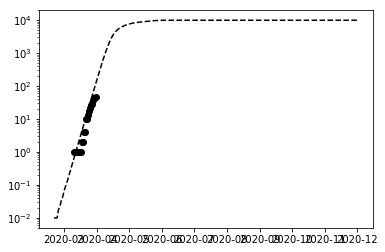

In [117]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['M'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['average_recover'])*0.01
plt.plot(x_off, y_off, 'ko', label = 'data')
plt.plot(x_mod, y_mod, 'k--', label = 'model')
plt.yscale('log')

In [131]:
v1=np.arange(0.0001,0.15,0.0001)
chi_2 = dict()
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
for par in v1:
    chi_2[par], kk = chi2(df_merged, 'UCI', 'av_Infected', par)
minchi = np.min(list(chi_2.values()))
print(minchi)
for key, value in chi_2.items():
    if value == minchi:
        print(key)

1971.6024045748995
0.0011


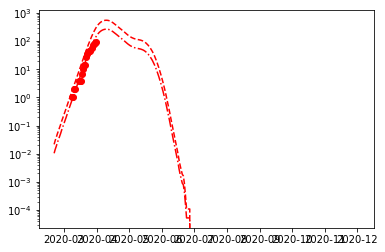

In [139]:
df_shifted = shift(df_simu, dayshift)
df_merged = pd.merge(df_shifted, df_epi, on = 'Día')
x_off = df_merged['Día']
y_off = np.array(df_merged['UCI'])
x_mod = df_shifted['Día']
y_mod = np.array(df_shifted['av_Infected'])*0.0011
y_mod2 = np.array(df_shifted['av_Infected'])*0.00053
plt.plot(x_off, y_off, 'ro', label = 'data')
plt.plot(x_mod, y_mod, 'r--', label = 'model')
plt.plot(x_mod, y_mod2, 'r-.', label = 'model')
plt.yscale('log')